In [12]:
!pip install --quiet pandas scikit-learn matplotlib sentence-transformers


In [13]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer


In [14]:
# Load local model (downloads once, then cached)
model = SentenceTransformer('all-MiniLM-L6-v2')
print("✅ Loaded local embedding model successfully.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Loaded local embedding model successfully.


In [15]:
products = [
    {"id": 1, "name": "Boho Dress", "desc": "Flowy, earthy tones for festival vibes. Lightweight cotton, tassel details.", "vibes": ["boho","cozy","festival"]},
    {"id": 2, "name": "Urban Bomber Jacket", "desc": "Matte black bomber with street style edge. Structured fit for energetic urban chic.", "vibes": ["urban","edgy","chic"]},
    {"id": 3, "name": "Minimal White Tee", "desc": "Clean, crisp cotton tee — everyday minimalist staple.", "vibes": ["minimal","casual","clean"]},
    {"id": 4, "name": "Vintage Denim Jeans", "desc": "High-waisted, slightly worn look — retro festival and casual looks.", "vibes": ["retro","casual","vintage"]},
    {"id": 5, "name": "Silk Slip Dress", "desc": "Satin finish, elegant evening wear, soft glow and refined silhouette.", "vibes": ["elegant","evening","glam"]},
    {"id": 6, "name": "Athleisure Leggings", "desc": "Stretchy, breathable leggings for active city life and gym routines.", "vibes": ["sporty","active","urban"]},
    {"id": 7, "name": "Cozy Knit Cardigan", "desc": "Chunky knit, warm and soft — perfect for cozy evenings and layered looks.", "vibes": ["cozy","warm","homey"]},
    {"id": 8, "name": "Bright Floral Skirt", "desc": "Colorful floral print, playful and energetic — daytime summer vibes.", "vibes": ["playful","summer","bright"]}
]

df = pd.DataFrame(products)
df


,id,name,desc,vibes
0,1,Boho Dress,"Flowy, earthy tones for festival vibes. Lightw...","[boho, cozy, festival]"
1,2,Urban Bomber Jacket,Matte black bomber with street style edge. Str...,"[urban, edgy, chic]"
2,3,Minimal White Tee,"Clean, crisp cotton tee — everyday minimalist ...","[minimal, casual, clean]"
3,4,Vintage Denim Jeans,"High-waisted, slightly worn look — retro festi...","[retro, casual, vintage]"
4,5,Silk Slip Dress,"Satin finish, elegant evening wear, soft glow ...","[elegant, evening, glam]"
5,6,Athleisure Leggings,"Stretchy, breathable leggings for active city ...","[sporty, active, urban]"
6,7,Cozy Knit Cardigan,"Chunky knit, warm and soft — perfect for cozy ...","[cozy, warm, homey]"
7,8,Bright Floral Skirt,"Colorful floral print, playful and energetic —...","[playful, summer, bright]"


In [16]:
def make_text_for_embedding(row):
    vibes_text = " ".join(row['vibes'])
    return f"{row['name']}. {row['desc']} Vibes: {vibes_text}"

df['embed_text'] = df.apply(make_text_for_embedding, axis=1)
df[['name','embed_text']].head()


,name,embed_text
0,Boho Dress,"Boho Dress. Flowy, earthy tones for festival v..."
1,Urban Bomber Jacket,Urban Bomber Jacket. Matte black bomber with s...
2,Minimal White Tee,"Minimal White Tee. Clean, crisp cotton tee — e..."
3,Vintage Denim Jeans,"Vintage Denim Jeans. High-waisted, slightly wo..."
4,Silk Slip Dress,"Silk Slip Dress. Satin finish, elegant evening..."


In [17]:
def get_embedding(text):
    return model.encode(text)

embeddings = []
start = time.time()
for txt in df['embed_text']:
    emb = get_embedding(txt)
    embeddings.append(emb)
end = time.time()

df['embedding'] = embeddings
print(f"✅ Computed {len(embeddings)} embeddings in {end-start:.2f}s using local model.")


✅ Computed 8 embeddings in 0.37s using local model.


In [18]:
def find_top_k(query, k=3, threshold=0.7):
    t0 = time.time()
    q_emb = get_embedding(query)
    matrix = np.vstack(df['embedding'].values)
    sims = cosine_similarity([q_emb], matrix)[0]
    top_idx = sims.argsort()[::-1][:k]

    results = []
    for i in top_idx:
        results.append({
            "name": df.iloc[i]['name'],
            "desc": df.iloc[i]['desc'],
            "vibes": df.iloc[i]['vibes'],
            "score": float(sims[i])
        })

    latency = time.time() - t0
    fallback = results[0]['score'] < threshold
    return {"query": query, "results": results, "latency_s": latency, "fallback": fallback}


In [19]:
queries = [
    "energetic urban chic",
    "flowy festival outfit",
    "soft comfy sweater for evenings"
]

records = []
for q in queries:
    out = find_top_k(q)
    print("\n=== QUERY:", q)
    print("Latency (s):", round(out['latency_s'],3))
    for r in out['results']:
        print(f"  - {r['name']} (score: {r['score']:.3f}) vibes: {r['vibes']}")
    if out['fallback']:
        print(">>> No confident match (fallback triggered).")
    records.append({
        "query": q,
        "best_score": out['results'][0]['score'],
        "latency_s": out['latency_s'],
        "fallback": out['fallback']
    })

metrics_df = pd.DataFrame(records)
metrics_df



=== QUERY: energetic urban chic
Latency (s): 0.123
  - Urban Bomber Jacket (score: 0.531) vibes: ['urban', 'edgy', 'chic']
  - Athleisure Leggings (score: 0.409) vibes: ['sporty', 'active', 'urban']
  - Bright Floral Skirt (score: 0.318) vibes: ['playful', 'summer', 'bright']
>>> No confident match (fallback triggered).

=== QUERY: flowy festival outfit
Latency (s): 0.162
  - Silk Slip Dress (score: 0.538) vibes: ['elegant', 'evening', 'glam']
  - Boho Dress (score: 0.476) vibes: ['boho', 'cozy', 'festival']
  - Vintage Denim Jeans (score: 0.444) vibes: ['retro', 'casual', 'vintage']
>>> No confident match (fallback triggered).

=== QUERY: soft comfy sweater for evenings
Latency (s): 0.066
  - Cozy Knit Cardigan (score: 0.504) vibes: ['cozy', 'warm', 'homey']
  - Silk Slip Dress (score: 0.382) vibes: ['elegant', 'evening', 'glam']
  - Minimal White Tee (score: 0.376) vibes: ['minimal', 'casual', 'clean']
>>> No confident match (fallback triggered).


,query,best_score,latency_s,fallback
0,energetic urban chic,0.530941,0.122855,True
1,flowy festival outfit,0.537926,0.161994,True
2,soft comfy sweater for evenings,0.503883,0.065560,True


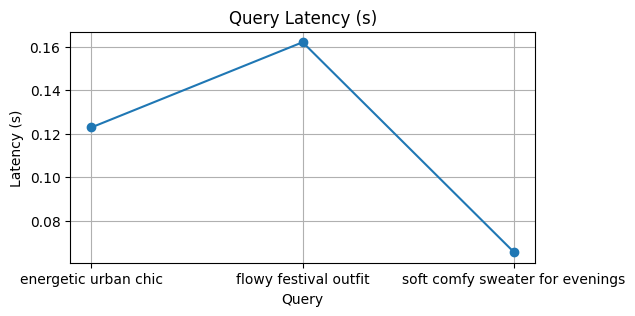

In [20]:
plt.figure(figsize=(6,3))
plt.plot(metrics_df['query'], metrics_df['latency_s'], marker='o')
plt.title("Query Latency (s)")
plt.xlabel("Query")
plt.ylabel("Latency (s)")
plt.grid(True)
plt.show()


In [23]:
def fallback_prompt(query):
    return f"We couldn't find a good match for '{query}'. Try broadening the vibe like 'casual summer' or 'formal evening'."

test = find_top_k("ultra futuristic metallic rave")
if test['fallback']:
    print("FALLBACK:", fallback_prompt(test['query']))


FALLBACK: We couldn't find a good match for 'ultra futuristic metallic rave'. Try broadening the vibe like 'casual summer' or 'formal evening'.


In [22]:
df_to_save = df.copy()
df_to_save['embedding'] = df_to_save['embedding'].apply(lambda e: ",".join(map(str, e[:10])) + " ...")
df_to_save.to_csv("vibe_products_preview.csv", index=False)
print("✅ Saved vibe_products_preview.csv")

from google.colab import files
files.download("vibe_products_preview.csv")


✅ Saved vibe_products_preview.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
!pip install --quiet sentence-transformers pandas numpy scikit-learn matplotlib


In [25]:
import pandas as pd
import numpy as np
import time
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


In [26]:
# Load the dataset
file_path = "/content/vibe_products_preview.csv"  # Change path if needed
df = pd.read_csv(file_path)

print("✅ File loaded successfully!")
print("\nColumns:", df.columns.tolist())
print("\nPreview:\n", df.head())


✅ File loaded successfully!

Columns: ['id', 'name', 'desc', 'vibes', 'embed_text', 'embedding']

Preview:
    id                 name                                               desc  \
0   1           Boho Dress  Flowy, earthy tones for festival vibes. Lightw...   
1   2  Urban Bomber Jacket  Matte black bomber with street style edge. Str...   
2   3    Minimal White Tee  Clean, crisp cotton tee — everyday minimalist ...   
3   4  Vintage Denim Jeans  High-waisted, slightly worn look — retro festi...   
4   5      Silk Slip Dress  Satin finish, elegant evening wear, soft glow ...   

                            vibes  \
0    ['boho', 'cozy', 'festival']   
1       ['urban', 'edgy', 'chic']   
2  ['minimal', 'casual', 'clean']   
3  ['retro', 'casual', 'vintage']   
4  ['elegant', 'evening', 'glam']   

                                          embed_text  \
0  Boho Dress. Flowy, earthy tones for festival v...   
1  Urban Bomber Jacket. Matte black bomber with s...   
2  Minimal Whi

In [27]:
# Load the free transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

def get_embedding(text):
    """Convert text into vector embeddings"""
    return model.encode(text)


In [28]:
embeddings = []
start = time.time()

for txt in df['embed_text']:
    emb = get_embedding(txt)
    embeddings.append(emb)

end = time.time()

df['embedding'] = embeddings
print(f"✅ Computed {len(embeddings)} embeddings in {end-start:.2f}s using free local model.")


✅ Computed 8 embeddings in 0.42s using free local model.


In [29]:
def find_top_k(query, k=3, threshold=0.45):
    """Find top-k similar products based on vibe similarity"""
    query_emb = get_embedding(query)
    all_embs = np.vstack(df['embedding'].values)
    sims = cosine_similarity([query_emb], all_embs)[0]

    top_indices = sims.argsort()[::-1][:k]
    top_scores = sims[top_indices]

    # If no match is strong enough, trigger fallback
    fallback = all(score < threshold for score in top_scores)

    results = df.iloc[top_indices][['name', 'desc', 'vibes']].copy()
    results['similarity'] = top_scores

    return {
        'query': query,
        'results': results,
        'fallback': fallback
    }


In [30]:
query = "casual summer outfit"
result = find_top_k(query)

print(f"\n🧠 Query: {result['query']}\n")
print(result['results'])




🧠 Query: casual summer outfit

                  name                                               desc  \
7  Bright Floral Skirt  Colorful floral print, playful and energetic —...   
3  Vintage Denim Jeans  High-waisted, slightly worn look — retro festi...   
4      Silk Slip Dress  Satin finish, elegant evening wear, soft glow ...   

                             vibes  similarity  
7  ['playful', 'summer', 'bright']    0.571955  
3   ['retro', 'casual', 'vintage']    0.545871  
4   ['elegant', 'evening', 'glam']    0.503541  


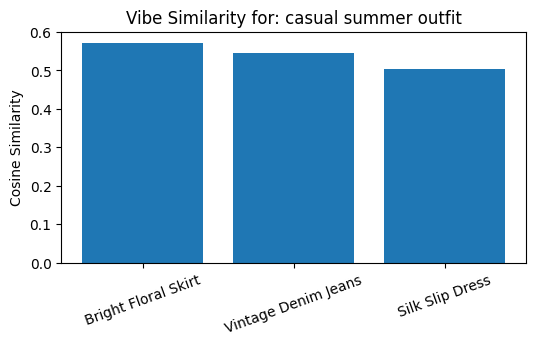

In [31]:
plt.figure(figsize=(6,3))
plt.bar(result['results']['name'], result['results']['similarity'])
plt.title(f"Vibe Similarity for: {result['query']}")
plt.xticks(rotation=20)
plt.ylabel("Cosine Similarity")
plt.show()


In [32]:
def fallback_prompt(query):
    return f"We couldn't find a good match for '{query}'. Try broadening the vibe like 'casual summer' or 'formal evening'."

test = find_top_k("ultra futuristic metallic rave")
if test['fallback']:
    print("FALLBACK:", fallback_prompt(test['query']))
else:
    print(test['results'])


FALLBACK: We couldn't find a good match for 'ultra futuristic metallic rave'. Try broadening the vibe like 'casual summer' or 'formal evening'.


In [33]:
result2 = find_top_k("retro denim style")
print("\n🎯 Query:", result2['query'])
print(result2['results'])



🎯 Query: retro denim style
                  name                                               desc  \
3  Vintage Denim Jeans  High-waisted, slightly worn look — retro festi...   
1  Urban Bomber Jacket  Matte black bomber with street style edge. Str...   
4      Silk Slip Dress  Satin finish, elegant evening wear, soft glow ...   

                            vibes  similarity  
3  ['retro', 'casual', 'vintage']    0.797775  
1       ['urban', 'edgy', 'chic']    0.514481  
4  ['elegant', 'evening', 'glam']    0.490280  


In [34]:
df.to_csv("vibe_products_with_embeddings.csv", index=False)
print("✅ File saved with embeddings added!")



✅ File saved with embeddings added!


In [35]:
from google.colab import files
files.download("vibe_products_with_embeddings.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>